# Лабораторная работа №7. Машинное обучение

Задача: анализ контингента посетителей магазинов по кадрам с видеокамер. Может применяться для определения того, какие категории людей чаще посещают те или иные отделы, а также для составления маркетинговых стратегий, проведения акций и скидок.

### Распаковка файлов и предварительная обработка

In [ ]:
import os
import tarfile
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_dir = './face_data/'
extract_dir = './faces'

os.makedirs(extract_dir, exist_ok=True)

for i in range(1, 4):
    archive_path = os.path.join(data_dir, f'part{i}.tar.gz')
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

In [ ]:
for root, dirs, files in os.walk('./faces'):
    print(f"Каталог: {root}")
    if files:
        print(f"Файлы: {files[:5]}")

Каталог: /content/drive/MyDrive/Labs_MO/faces
Каталог: /content/drive/MyDrive/Labs_MO/faces/part2
Файлы: ['30_1_1_20170112215105568.jpg', '32_0_0_20170117182315092.jpg', '38_0_0_20170117153835602.jpg', '26_0_1_20170113154700499.jpg', '55_0_1_20170117180249950.jpg']
Каталог: /content/drive/MyDrive/Labs_MO/faces/part3
Файлы: ['44_0_3_20170119200652604.jpg', '78_1_0_20170120224727472.jpg', '44_1_3_20170119164705141.jpg', '55_1_3_20170119195255556.jpg', '35_1_0_20170120220747764.jpg']
Каталог: /content/drive/MyDrive/Labs_MO/faces/part1
Файлы: ['20_1_4_20161223230050564.jpg', '57_0_0_20170104202107434.jpg', '2_1_2_20161219151500019.jpg', '28_1_2_20170104021815094.jpg', '90_0_2_20170111210740854.jpg']
Каталог: /content/drive/MyDrive/Labs_MO/faces
Пример файлов: []


In [ ]:
data_root = './faces'
subfolders = ['part1', 'part2', 'part3']

def get_age_category(age):
    if age <= 12:
        return 0  # child
    elif age <= 19:
        return 1  # teen
    elif age <= 39:
        return 2  # young adult
    elif age <= 59:
        return 3  # middle age
    else:
        return 4  # senior

data = []

for folder in subfolders:
    folder_path = os.path.join(data_root, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            try:
                age, gender, *_ = filename.split('_')
                age = int(age)
                gender = int(gender)
                age_cat = get_age_category(age)
                full_path = os.path.join(folder_path, filename)
                data.append([full_path, age_cat, gender])
            except Exception as e:
                print(f"Пропущен файл {filename}: {e}")

df = pd.DataFrame(data, columns=['image_path', 'age_category', 'gender'])
print(f"Всего изображений: {len(df)}")
df.head()

Пропущен файл 53__0_20170116184028385.jpg: invalid literal for int() with base 10: ''
Всего изображений: 24105


,image_path,age_category,gender
0,/content/drive/MyDrive/Labs_MO/faces/part1/20_...,2,1
1,/content/drive/MyDrive/Labs_MO/faces/part1/57_...,3,0
2,/content/drive/MyDrive/Labs_MO/faces/part1/2_1...,0,1
3,/content/drive/MyDrive/Labs_MO/faces/part1/28_...,2,1
4,/content/drive/MyDrive/Labs_MO/faces/part1/90_...,4,0


In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


class FaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image_path = row['image_path']

        try:
            img = Image.open(image_path).convert('RGB')
        except (UnidentifiedImageError, FileNotFoundError):
            # Если изображение не читается — пробуем следующий по индексу
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            img = self.transform(img)

        age = torch.tensor(row['age_category'], dtype=torch.long)
        gender = torch.tensor(row['gender'], dtype=torch.long)

        return img, {'age': age, 'gender': gender}

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24105 entries, 0 to 24104
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_path    24105 non-null  object
 1   age_category  24105 non-null  int64 
 2   gender        24105 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 565.1+ KB


Тут откуда-то взялось некорректное значение признака gender, его удаляем

In [ ]:
unique_combinations = df[['age_category', 'gender']].drop_duplicates()
print(unique_combinations)

      age_category  gender
0                2       1
1                3       0
2                0       1
4                4       0
7                3       1
9                4       1
13               1       0
15               0       0
17               1       1
35               2       0
9961             4       3


In [ ]:
df = df[df['gender'].isin([0, 1])].reset_index(drop=True)

### Подготовка моделей

In [ ]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df[['age_category', 'gender']],
    random_state=42
)

В качестве backbone модели будем использовать ResNet18

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MultiTaskResNet18(nn.Module):
    def __init__(self, dropout=0.5):
        super(MultiTaskResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.fc_age = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 5)
        )

        self.fc_gender = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x_res = self.resnet(x)
        age_output = self.fc_age(x_res)
        gender_output = self.fc_gender(x_res)
        return {'age': age_output, 'gender': gender_output}

In [ ]:
def train_epoch(model, loader, optimizer, criterion_age, criterion_gender):
    model.train()
    running_loss = 0.0
    correct_age = 0
    correct_gender = 0
    total = 0

    pbar = tqdm(loader, desc="Training", leave=False)

    for imgs, labels in pbar:
        imgs = imgs.to(device)
        age_labels = labels['age'].to(device)
        gender_labels = labels['gender'].to(device)

        outputs = model(imgs)
        loss_age = criterion_age(outputs['age'], age_labels)
        loss_gender = criterion_gender(outputs['gender'], gender_labels)
        loss = loss_age + loss_gender

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, age_preds = torch.max(outputs['age'], 1)
        _, gender_preds = torch.max(outputs['gender'], 1)

        correct_age += (age_preds == age_labels).sum().item()
        correct_gender += (gender_preds == gender_labels).sum().item()
        total += age_labels.size(0)

    avg_loss = running_loss / len(loader)
    acc_age = correct_age / total
    acc_gender = correct_gender / total

    return avg_loss, acc_age, acc_gender


def validate_epoch(model, loader, criterion_age, criterion_gender):
    model.eval()
    running_loss = 0.0
    correct_age = 0
    correct_gender = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            age_labels = labels['age'].to(device)
            gender_labels = labels['gender'].to(device)

            outputs = model(imgs)
            loss_age = criterion_age(outputs['age'], age_labels)
            loss_gender = criterion_gender(outputs['gender'], gender_labels)
            loss = loss_age + loss_gender

            running_loss += loss.item()

            _, age_preds = torch.max(outputs['age'], 1)
            _, gender_preds = torch.max(outputs['gender'], 1)

            correct_age += (age_preds == age_labels).sum().item()
            correct_gender += (gender_preds == gender_labels).sum().item()
            total += age_labels.size(0)

    avg_loss = running_loss / len(loader)
    acc_age = correct_age / total
    acc_gender = correct_gender / total

    return avg_loss, acc_age, acc_gender

In [ ]:
def train_and_validate_model(batch_size, lr, dropout, num_epochs=3):
    model = MultiTaskResNet18(dropout=dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion_age = nn.CrossEntropyLoss()
    criterion_gender = nn.CrossEntropyLoss()

    train_loader = DataLoader(
        FaceDataset(train_df, transform=image_transforms),
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        FaceDataset(val_df, transform=image_transforms),
        batch_size=batch_size,
        shuffle=False
    )

    for epoch in range(num_epochs):
        train_loss, train_acc_age, train_acc_gender = train_epoch(
            model, train_loader, optimizer, criterion_age, criterion_gender)

        val_loss, val_acc_age, val_acc_gender = validate_epoch(
            model, val_loader, criterion_age, criterion_gender)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Age Acc: {train_acc_age:.4f} | Gender Acc: {train_acc_gender:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Age Acc: {val_acc_age:.4f} | Gender Acc: {val_acc_gender:.4f}")

    return model, val_loss, val_acc_age, val_acc_gender

Обучим три модели с разными комбинациями значений параметров batch_size, lr и dropout

### Обучение и результаты первой модели

Метрики и уже обученную модель сохраним для дальнейшего использования

In [ ]:
os.makedirs('results', exist_ok=True)

model_1, val_loss_1, val_acc_age_1, val_acc_gender_1 = train_and_validate_model(
    batch_size=32,
    lr=1e-3,
    dropout=0.3
)

metrics_1 = {
    'batch_size': 32,
    'learning_rate': 1e-3,
    'dropout': 0.3,
    'val_loss': val_loss_1,
    'val_acc_age': val_acc_age_1,
    'val_acc_gender': val_acc_gender_1
}
with open('results/metrics_model_1.json', 'w') as f:
    json.dump(metrics_1, f, indent=4)

torch.save(model_1.state_dict(), 'results/model_1_weights.pt')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.3MB/s]


Epoch 1/3
  Train Loss: 1.1792 | Age Acc: 0.6844 | Gender Acc: 0.8436
  Val   Loss: 1.1919 | Age Acc: 0.6470 | Gender Acc: 0.8787


Epoch 2/3
  Train Loss: 0.9378 | Age Acc: 0.7402 | Gender Acc: 0.8917
  Val   Loss: 0.9100 | Age Acc: 0.7449 | Gender Acc: 0.8899


Epoch 3/3
  Train Loss: 0.8163 | Age Acc: 0.7701 | Gender Acc: 0.9049
  Val   Loss: 0.9200 | Age Acc: 0.7370 | Gender Acc: 0.8996


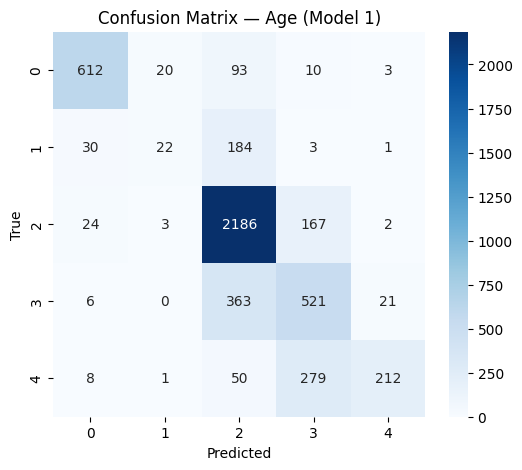

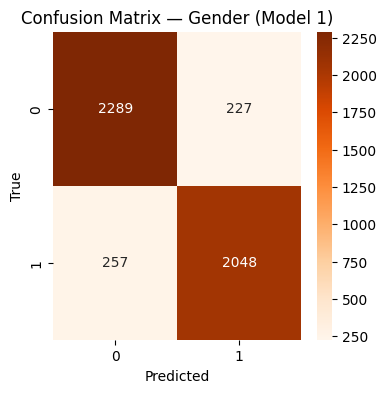

In [ ]:
val_loader = DataLoader(
    FaceDataset(val_df, transform=image_transforms),
    batch_size=32,
    shuffle=False
)

all_age_preds, all_age_labels = [], []
all_gender_preds, all_gender_labels = [], []

model_1.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        age_labels = labels['age'].to(device)
        gender_labels = labels['gender'].to(device)

        outputs = model_1(images)
        age_preds = torch.argmax(outputs['age'], dim=1)
        gender_preds = torch.argmax(outputs['gender'], dim=1)

        all_age_preds.extend(age_preds.cpu().numpy())
        all_age_labels.extend(age_labels.cpu().numpy())
        all_gender_preds.extend(gender_preds.cpu().numpy())
        all_gender_labels.extend(gender_labels.cpu().numpy())

cm_age = confusion_matrix(all_age_labels, all_age_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm_age, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — Age (Model 1)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/confusion_age_model_1.png')
plt.show()

cm_gender = confusion_matrix(all_gender_labels, all_gender_preds)
plt.figure(figsize=(4,4))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix — Gender (Model 1)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/confusion_gender_model_1.png')
plt.show()

### Обучение и результаты второй модели

In [ ]:
model_2, val_loss_2, val_acc_age_2, val_acc_gender_2 = train_and_validate_model(
    batch_size=64,
    lr=1e-4,
    dropout=0.5
)

metrics_2 = {
    'batch_size': 64,
    'learning_rate': 1e-4,
    'dropout': 0.5,
    'val_loss': val_loss_2,
    'val_acc_age': val_acc_age_2,
    'val_acc_gender': val_acc_gender_2
}

with open('results/metrics_model_2.json', 'w') as f:
    json.dump(metrics_2, f, indent=4)

torch.save(model_2.state_dict(), 'results/model_2_weights.pt')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3
  Train Loss: 1.0080 | Age Acc: 0.7208 | Gender Acc: 0.8837
  Val   Loss: 0.7532 | Age Acc: 0.7924 | Gender Acc: 0.9264


Epoch 2/3
  Train Loss: 0.6156 | Age Acc: 0.8199 | Gender Acc: 0.9456
  Val   Loss: 0.7658 | Age Acc: 0.7853 | Gender Acc: 0.9218


Epoch 3/3
  Train Loss: 0.3966 | Age Acc: 0.8783 | Gender Acc: 0.9700
  Val   Loss: 0.8470 | Age Acc: 0.7822 | Gender Acc: 0.9255


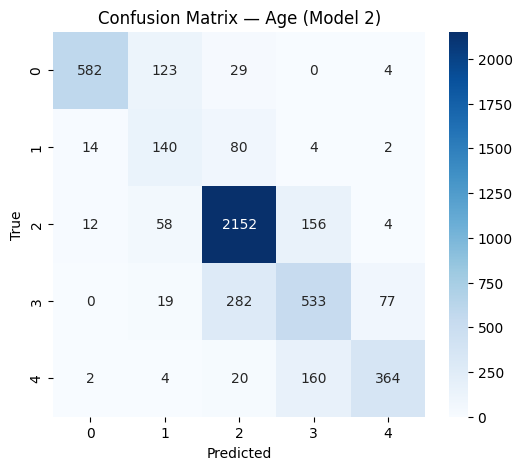

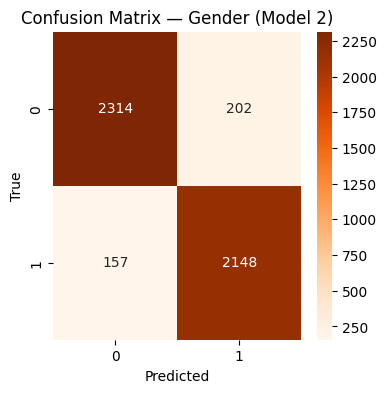

In [ ]:
val_loader_2 = DataLoader(
    FaceDataset(val_df, transform=image_transforms),
    batch_size=64,
    shuffle=False
)

all_age_preds_2, all_age_labels_2 = [], []
all_gender_preds_2, all_gender_labels_2 = [], []

model_2.eval()
with torch.no_grad():
    for images, labels in val_loader_2:
        images = images.to(device)
        age_labels = labels['age'].to(device)
        gender_labels = labels['gender'].to(device)

        outputs = model_2(images)
        age_preds = torch.argmax(outputs['age'], dim=1)
        gender_preds = torch.argmax(outputs['gender'], dim=1)

        all_age_preds_2.extend(age_preds.cpu().numpy())
        all_age_labels_2.extend(age_labels.cpu().numpy())
        all_gender_preds_2.extend(gender_preds.cpu().numpy())
        all_gender_labels_2.extend(gender_labels.cpu().numpy())

cm_age_2 = confusion_matrix(all_age_labels_2, all_age_preds_2)
plt.figure(figsize=(6,5))
sns.heatmap(cm_age_2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — Age (Model 2)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/confusion_age_model_2.png')
plt.show()

cm_gender_2 = confusion_matrix(all_gender_labels_2, all_gender_preds_2)
plt.figure(figsize=(4,4))
sns.heatmap(cm_gender_2, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix — Gender (Model 2)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/confusion_gender_model_2.png')
plt.show()

### Обучение и результаты третьей модели

In [ ]:
model_3, val_loss_3, val_acc_age_3, val_acc_gender_3 = train_and_validate_model(
    batch_size=32,
    lr=1e-4,
    dropout=0.3
)

metrics_3 = {
    'batch_size': 32,
    'learning_rate': 1e-4,
    'dropout': 0.3,
    'val_loss': val_loss_3,
    'val_acc_age': val_acc_age_3,
    'val_acc_gender': val_acc_gender_3
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.9MB/s]


Epoch 1/3
  Train Loss: 0.9822 | Age Acc: 0.7338 | Gender Acc: 0.8813
  Val   Loss: 0.7818 | Age Acc: 0.7859 | Gender Acc: 0.9038


Epoch 2/3
  Train Loss: 0.6245 | Age Acc: 0.8190 | Gender Acc: 0.9419
  Val   Loss: 0.7771 | Age Acc: 0.7787 | Gender Acc: 0.9222


Epoch 3/3
  Train Loss: 0.4209 | Age Acc: 0.8732 | Gender Acc: 0.9647
  Val   Loss: 0.8364 | Age Acc: 0.7658 | Gender Acc: 0.9214


FileNotFoundError: [Errno 2] No such file or directory: 'results/metrics_model_3.json'

Тут немного навернулась система, но чтобы не обучать повторно, было решено оставить так

In [ ]:
os.makedirs('results', exist_ok=True)
with open('results/metrics_model_3.json', 'w') as f:
    json.dump(metrics_3, f, indent=4)

torch.save(model_3.state_dict(), 'results/model_3_weights.pt')

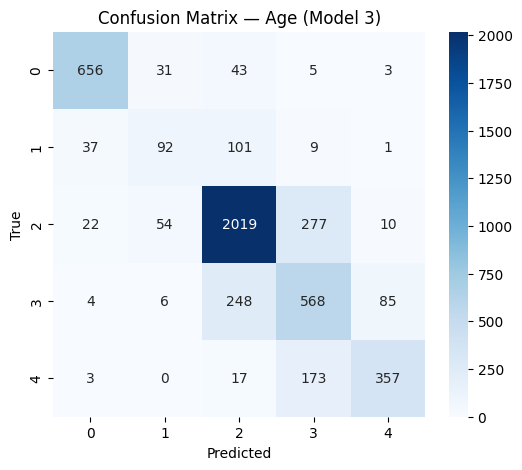

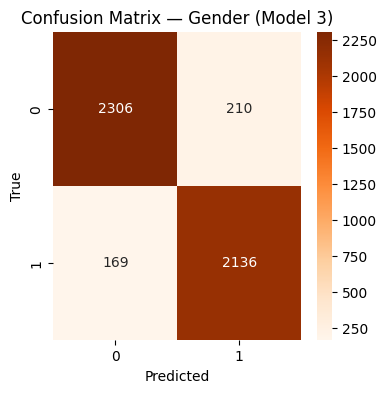

In [ ]:
val_loader_3 = DataLoader(
    FaceDataset(val_df, transform=image_transforms),
    batch_size=32,
    shuffle=False
)

all_age_preds_3, all_age_labels_3 = [], []
all_gender_preds_3, all_gender_labels_3 = [], []

model_3.eval()
with torch.no_grad():
    for images, labels in val_loader_3:
        images = images.to(device)
        age_labels = labels['age'].to(device)
        gender_labels = labels['gender'].to(device)

        outputs = model_3(images)
        age_preds = torch.argmax(outputs['age'], dim=1)
        gender_preds = torch.argmax(outputs['gender'], dim=1)

        all_age_preds_3.extend(age_preds.cpu().numpy())
        all_age_labels_3.extend(age_labels.cpu().numpy())
        all_gender_preds_3.extend(gender_preds.cpu().numpy())
        all_gender_labels_3.extend(gender_labels.cpu().numpy())

cm_age_3 = confusion_matrix(all_age_labels_3, all_age_preds_3)
plt.figure(figsize=(6,5))
sns.heatmap(cm_age_3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — Age (Model 3)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/confusion_age_model_3.png')
plt.show()

cm_gender_3 = confusion_matrix(all_gender_labels_3, all_gender_preds_3)
plt.figure(figsize=(4,4))
sns.heatmap(cm_gender_3, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix — Gender (Model 3)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/confusion_gender_model_3.png')
plt.show()

Вывод: лучшая модель - вторая, судя по значениям в матрицах путаницы и значениям как по возрасту, так и по гендеру